# Implementação Algoritmo de Grover

Este notebook traz uma implementação genérica do Algoritmo de Grover. A implementação pode ser modificada, alterando-se o portão oráculo para contextos mais específicos, bem como pode-se estender a quantidade de qubits utilizados.

## O algoritmo

O Algoritmo de Grover é um algoritmo quântico proposto por Lov Grover, em 1989, para a realização de busca de informações em bancos de dados desordenados [1](	arXiv:quant-ph/9605043). Ele funciona por meio de um processo iterativo de consulta à um oráculo, portão que é capaz de marcar estados com determinadas características realizando uma alteração de fase de $\pi$, e um difusor, que realiza a inversão sobre e média dos estados, de modo a amplificar o estado de interesse em detrimento dos demais.

## Implementação

### Importação de bibliotecas e pacotes

In [35]:
import numpy as np
from math import floor, pi, sqrt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

### Ajuste de parâmetros iniciais

In [63]:
# Parâmetros
n = 6                        # número de qubits
N = 2 ** n                   # espaço de busca (quantidade de cadeias com n qubits existem)
target_str = "110110"        # string que o algoritmo tentará encontrar

# conversão para índice compatível com a ordem do Qiskit (lsb -> msb)
# a ideia é inverter a string para obter o índice correto
target_index = int(target_str[::-1], 2)

### Criação dos blocos principais
Aqui estão descritos a criação do Oráculo de consulta e do Difusor

In [ ]:
# Criação do oráculo: matriz diagonal com -1 apenas na posição do alvo
oracle_matrix = np.eye(N, dtype=complex)
oracle_matrix[target_index, target_index] = -1
oracle_op = Operator(oracle_matrix)

# Criação do operador de difusão com numpy
s = np.ones(N) / np.sqrt(N)
diffusion_matrix = 2.0 * np.outer(s, s) - np.eye(N)
diffusion_op = Operator(diffusion_matrix)

# Encontrando o número ideal de iterações
r_opt = floor((pi / 4) * sqrt(N))   # para N=16 -> floor(pi) = 3

In [62]:
print(oracle_matrix)

[[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]]


### Criação do circuito final

In [65]:
# Criação do circuito base
qc = QuantumCircuit(n, n)        # n qubits + n bits clássicos para medir
qc.h(range(n))                   # superposição inicial

# Adiciona a cadeia iterativa entre oracle e difusor
for _ in range(r_opt):
    qc.append(oracle_op.to_instruction(), range(n))
    qc.append(diffusion_op.to_instruction(), range(n))

qc.barrier()

# Mede os estados
qc.measure(range(n), range(n))

Visualização do circuito final:

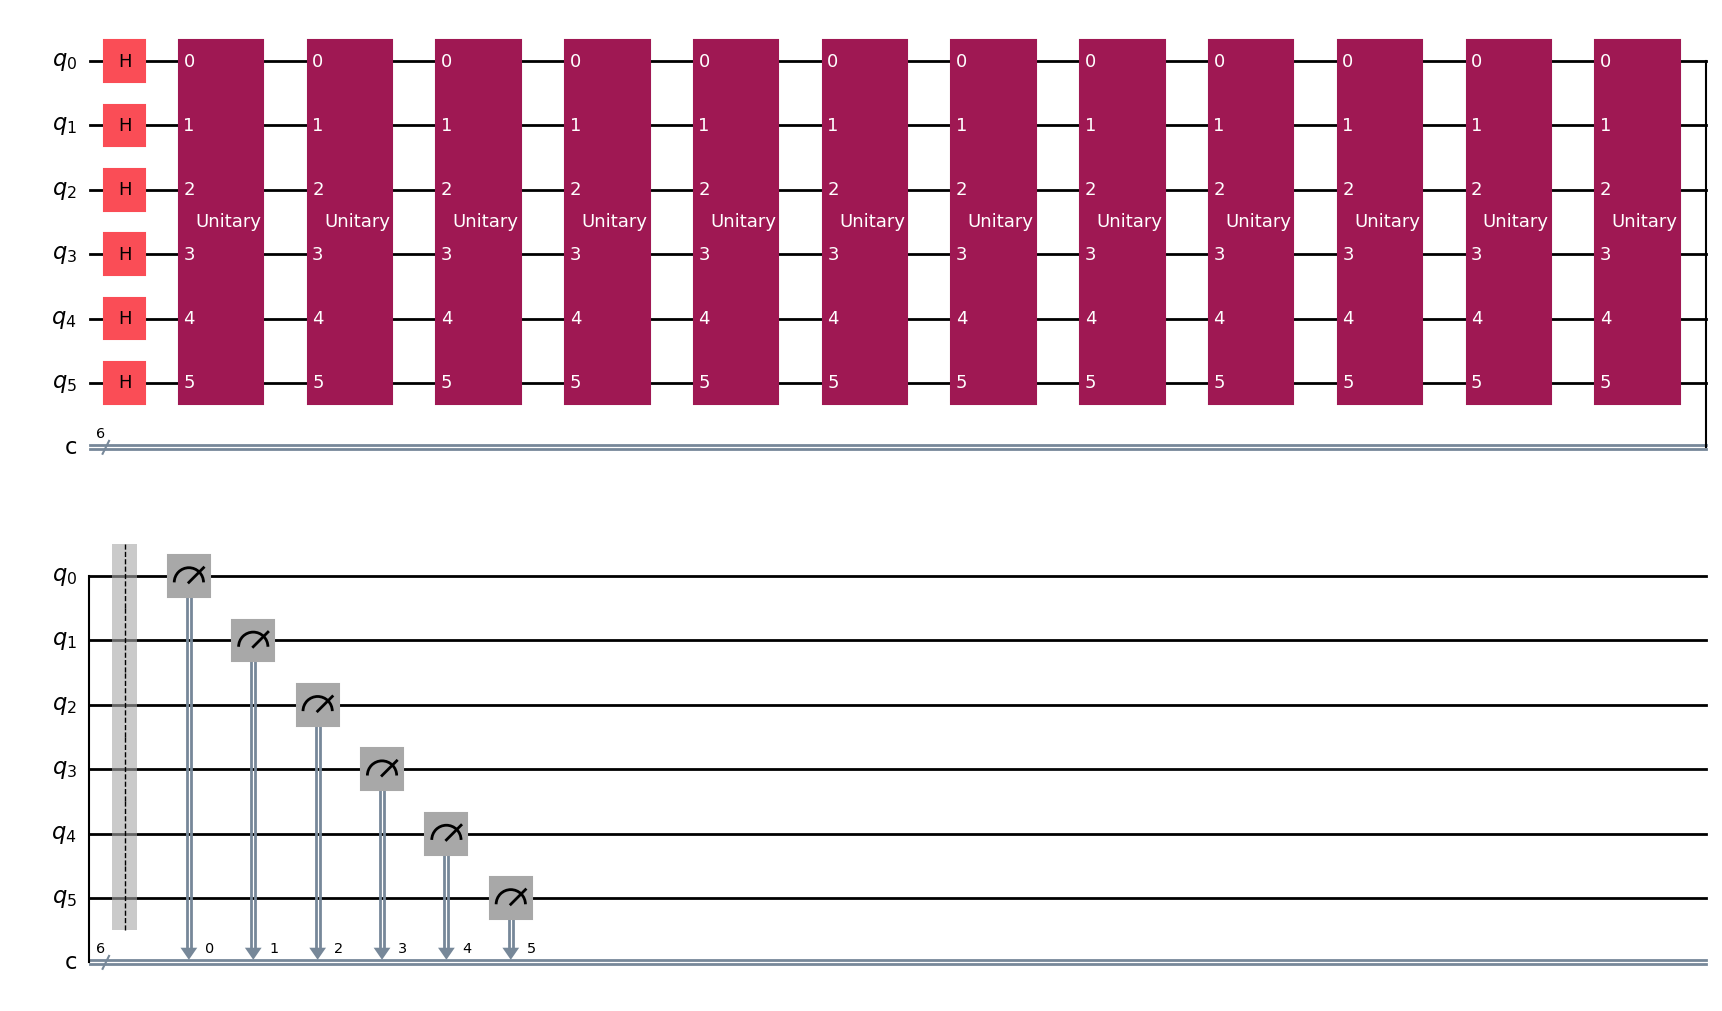

In [66]:
qc.draw('mpl')

### Simulação clássica do circuito

Aqui, o circuito é simulado classicamente. Não foi implementada técnicas para redução da carga da simulação no hardware, tampouco otimizações para uso de GPUs ou TPUs. Nesse contexto, cuidado com a quantidade de qubits simulados. Até 6 qubits deve ser uma tarefa factível para a maioria dos computadores.

In [ ]:
backend = AerSimulator()                               # Backend simulado
tqc = transpile(qc, backend)                           # Transpilação do circuito para o backend específico 
job = backend.run(tqc, backend=backend, shots=2048)    # Execução da simulação com 2048 shots (repetições)
result = job.result()                                  # Coleta o resultado da execução
counts = result.get_counts()                           # contagem dos resultados

### Observação dos resultados

A partir da execução anteriores, a seguir, está o histograma com a ocorrência de cada uma das possíveis cadeias ser aquela que satisfaz o determinado pelo oráculo.

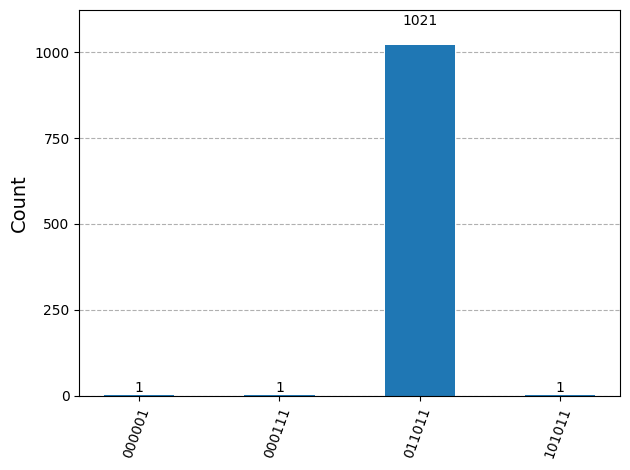

In [49]:
plot_histogram(counts)